# Find parameters of the neck's motion in the head's coordinate system

In [1]:
# Import packages
import cv2
import cc3d #connected components in 3D
import numpy as np
import pandas as pd
from skimage import io
from skimage import morphology
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import matplotlib.animation as animation
%matplotlib notebook

In [2]:
# Define functions
def read(filename):
    volume_time = io.imread(filename)
    t,z,x,y = volume_time.shape
    return volume_time,t,z,x,y

def find_neck(time_frame, img_c, img_h, labels_c, labels_h, chosen_label_c, chosen_label_h, it):
    # I remove the parts of the image which do not belong to the label chosen
    img_h[np.where(labels_h!=chosen_label_h)] = 0    
    img_h = img_h.astype('bool')
    
    img_c[np.where(labels_c!=chosen_label_c)] = 0
    img_c = img_c.astype('bool')

    # I dilate two times and compute the difference
    dilation1 = ndi.binary_dilation(img_h, morphology.ball(radius=2), iterations=it)
    dilation2 = ndi.binary_dilation(img_h, morphology.ball(radius=2), iterations=(it+3))
    band1 = dilation2^dilation1
    #? do connected components here to assure that we'll do the mean of only the neck?
    
    # Where the ring of dilation and the cell segmentation overlap, there is the neck
    neck = np.where(band1&img_cell==True)
    if len(neck[0])>0:
        z,y,x = np.mean(neck, axis=1)
    else:
        x,y,z = [0,0,0] #in case there's no overlapping
               
    return x,y,z  

### Read the segmented cell and head

In [3]:
# t, z, y, x are the same for the head and whole cell segmentations
_, t, z, y, x = read('segmentation/sperm00068_t1_146_segmentation_head.tif')

print('Slices in Z:', z)
print('Time steps:', t)
print()
print("Rows or Height of frame:", y)
print("Columns or Width of frame:", x)

Slices in Z: 9
Time steps: 146

Rows or Height of frame: 139
Columns or Width of frame: 347


In [4]:
volume_time_head = io.imread('segmentation/sperm00068_t1_146_segmentation_head.tif')
volume_time_cell = io.imread('segmentation/sperm00068_t1_146_segmentation_cell.tif')

### Do connected components of the cell and head segmentations, and choose desired label manually

with the python script in _choose_label.py_

In [5]:
file_c = pd.read_csv('label_cell_done.txt', names=['cell'])
file_h = pd.read_csv('label_head_done.txt', names=['head'])

### Find the center of mass of the midpiece and PCA of the head

<IPython.core.display.Javascript object>


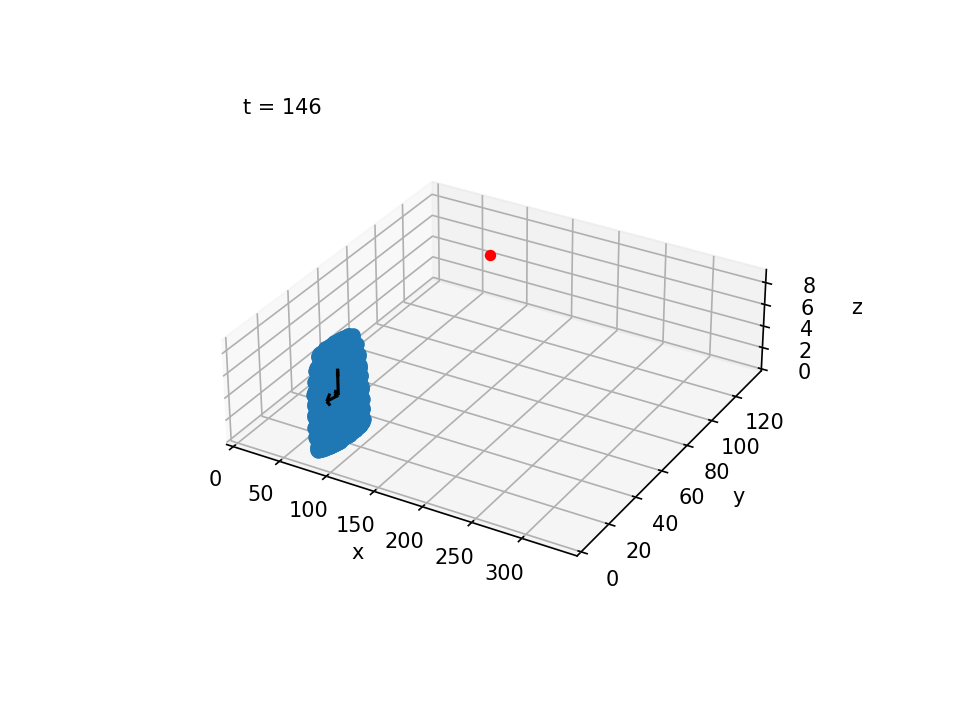

In [7]:
# Create an animation for all the timeframes
# Segmented points in blue, their coordinate system in black and the neck in red
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_box_aspect([1,1,0.3])

for ti in range(t):
    img_cell = volume_time_cell[ti]
    img_head = volume_time_head[ti]
    
    # Do connected components of the cell and head segmentations, and use the labels obtained manually
    labels_head = cc3d.connected_components(img_head)
    labels_cell = cc3d.connected_components(img_cell)
    chosen_label_cell = file_c['cell'][ti]
    chosen_label_head = file_h['head'][ti]
    
    if chosen_label_cell!=0 and chosen_label_head!=0:
        # Perform the PCA of the head
        k, j, i = np.where(labels_head==chosen_label_head)
        j = y-j
        head_full = np.array([i, j, k])
        origin = np.mean(head_full, axis=1)
        
        covMatrix = np.cov(head_full, bias=True) #bias is True to calculate the population covariance and not the sample one
        eigval, eigvec = np.linalg.eig(covMatrix)
        # The vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding
        # eigenvalue, and shifted so their tails are at the mean.
        vec = eigvec * np.sqrt(eigval)      
        
        # Find the point on the neck
        neck = find_neck(ti, img_cell, img_head, labels_cell, labels_head, chosen_label_cell, chosen_label_head, 3)
        #tail = find_neck(time_frame, img_cell, img_head, labels_cell, labels_head, chosen_label_cell, chosen_label_head, 6)
        
        if (ti%1==0):
            ax.clear()
            ax.text2D(0.05, 0.95, 't = %i' % (ti+1), transform=ax.transAxes) #placement (0,0) would be the bottom left, (0,1) would be the top left
            ax.plot3D(i, j, k, 'o')
            ax.scatter(*neck, c='r')
            #ax.scatter(*tail, c='b')
            ax.quiver(*origin, vec[0,:], vec[1,:], vec[2,:], color='k')
            ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
            ax.set_xlim(0,x); ax.set_ylim(0,y); ax.set_zlim(0,z)
            plt.show()

<IPython.core.display.Javascript object>


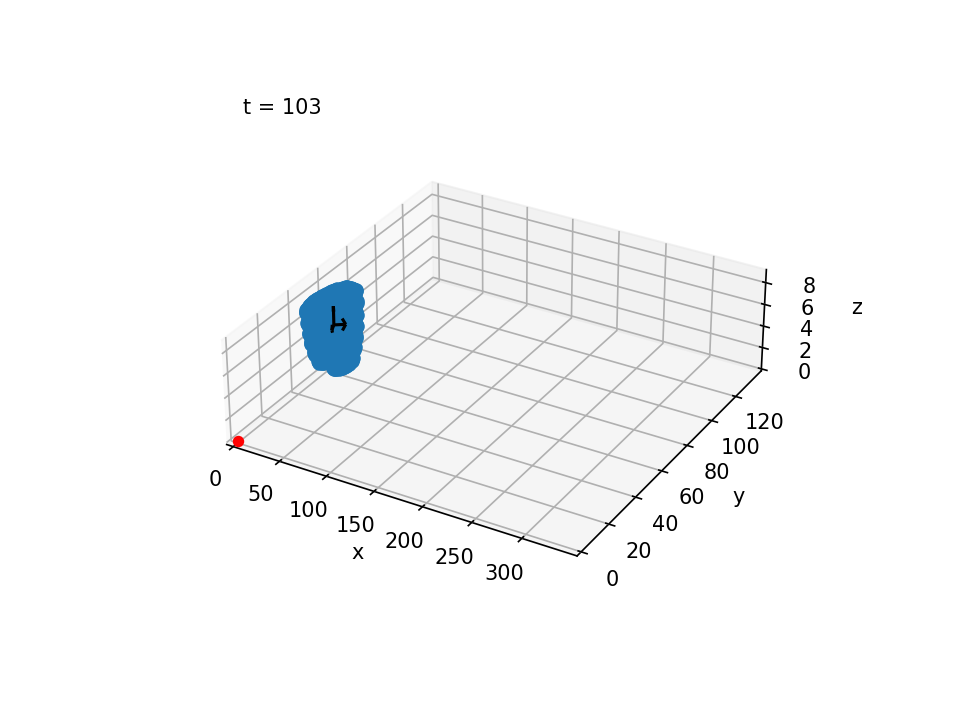

In [8]:
# Create an animation for all the timeframes
# Segmented points in blue, their coordinate system in black and the neck in red
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')
ax.set_box_aspect([1,1,0.3])

def anim3D(ti):    
    img_cell = volume_time_cell[ti]
    img_head = volume_time_head[ti]
    
    # Do connected components of the cell and head segmentations, and use the labels obtained manually
    labels_head = cc3d.connected_components(img_head)
    labels_cell = cc3d.connected_components(img_cell)
    chosen_label_cell = file_c['cell'][ti]
    chosen_label_head = file_h['head'][ti]
    
    if chosen_label_cell!=0 and chosen_label_head!=0:
        # Perform the PCA of the head
        k, j, i = np.where(labels_head==chosen_label_head)
        j = y-j
        head_full = np.array([i, j, k])
        origin = np.mean(head_full, axis=1)
        
        covMatrix = np.cov(head_full, bias=True) #bias is True to calculate the population covariance and not the sample one
        eigval, eigvec = np.linalg.eig(covMatrix)
        # The vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding
        # eigenvalue, and shifted so their tails are at the mean.
        vec = eigvec * np.sqrt(eigval)      
        
        # Find the point on the neck
        neck = find_neck(ti, img_cell, img_head, labels_cell, labels_head, chosen_label_cell, chosen_label_head, 3)
        #tail = find_neck(time_frame, img_cell, img_head, labels_cell, labels_head, chosen_label_cell, chosen_label_head, 6)
        
        if (ti%1==0):
            ax.clear()
            ax.text2D(0.05, 0.95, 't = %i' % (ti+1), transform=ax.transAxes) #placement (0,0) would be the bottom left, (0,1) would be the top left
            ax.plot3D(i, j, k, 'o')
            ax.scatter(*neck, c='r')
            #ax.scatter(*tail, c='b')
            ax.quiver(*origin, vec[0,:], vec[1,:], vec[2,:], color='k')
            ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
            ax.set_xlim(0,x); ax.set_ylim(0,y); ax.set_zlim(0,z)
            plt.show()
            
    return 0

ani = animation.FuncAnimation(fig, anim3D, t+1, interval=100, repeat=False, blit=True)